# Are we consuming more local?

## Research questions

1. Where are the products we consume in our everyday life coming from?

    - Which countries produce the primary resources (ground ingredients) consumed in Switzerland?
    - Which countries manufacture most of the products consumed in Switzerland?


2. Is there a trend over time to consume more local products?

    - Are new products mostly using primary resources from Switzerland? Or from other countries inside Europe?
    - Are new products mostly manufactured in Switzerland? Or from other countries inside Europe?
    - Is there a trend over time to local products to promote their origin?

## Datasets

Open Food Facts (https://world.openfoodfacts.org/data)

Additional datasets “Evolution de la consommation de denrées alimentaires en Suisse” (https://opendata.swiss/fr/dataset/entwicklung-des-nahrungsmittelverbrauches-in-der-schweiz-je-kopf-und-jahr1) and “Dépenses fédérales pour l’agriculture et l’alimentation” (https://opendata.swiss/fr/dataset/bundesausgaben-fur-die-landwirtschaft-und-die-ernahrung1) from https://opendata.swiss/fr/group/agriculture

A last additional dataset for the second question of the project
https://www.gate.ezv.admin.ch/swissimpex/public/bereiche/waren/result.xhtml
Total of imports of agriculture, forestry and fishing goods


In [2]:
import re
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import timedelta
import findspark
findspark.init()
import pyspark

from functools import reduce
from pyspark.sql import *
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.functions import min
from pyspark.sql.functions import to_date, last_day,date_add
from datetime import timedelta

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [3]:
DATA_FOLDER = 'data'
openfood_file = "/en.openfoodfacts.org.products.csv"
PARQUET_PATH = 'output/data.parquet'
temp_file = 'output/temp.csv'

# Loading data

In [327]:
dataset_main = spark.read.csv(DATA_FOLDER+ openfood_file, header=True, mode="DROPMALFORMED", sep = '\t')

dataset_main.createOrReplaceTempView("data_main")

# Filter required columns
p_id_col = " code, product_name "
general_cols = " brands, brands_tags, categories, categories_tags, origins, origins_tags, manufacturing_places, manufacturing_places_tags,labels,labels_tags,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags "
geo_cols = " origins, manufacturing_places, countries "
geo_tags_cols = " origins_tags, manufacturing_places_tags, countries_tags "

off_df = spark.sql("SELECT" + p_id_col +geo_tags_cols + " FROM data_main")
off_df.printSchema()

root
 |-- code: string (nullable = true)
 |-- origins_tags: string (nullable = true)
 |-- manufacturing_places_tags: string (nullable = true)
 |-- countries_tags: string (nullable = true)



## Data Cleaning and Preprocessing

In [5]:
off_df.createOrReplaceTempView("off_df")

sql_filter = "SELECT * FROM off_df WHERE countries_tags is not NULL AND manufacturing_places_tags is not NULL AND origins_tags is not NULL"
off_p_df = spark.sql(sql_filter)

# off_p_all_size = off_p_df.count()
# off_p_cols_size = len(off_p_df.columns)
# print("Full GEO information data Size:\n" + str(off_p_cols_size) + "(columns) * " + str(off_p_all_size) + "(rows)")

In [6]:
# Explode countries
off_p_df = off_p_df.withColumn('origins_tags', F.explode_outer(F.split('origins_tags', ',')))\
.withColumn('manufacturing_places_tags', F.explode_outer(F.split('manufacturing_places_tags', ',')))\
.withColumn('countries_tags', F.explode_outer(F.split('countries_tags', ',')))

# Remove "en:" occurances before name of each country in coutries_tags
off_p_df = off_p_df.withColumn('countries_tags', F.regexp_replace('countries_tags', "en:", ""))
# Remove - in name of countries
off_p_df = off_p_df.withColumn('countries_tags', F.regexp_replace('countries_tags', "-", " "))
off_p_df = off_p_df.withColumn('manufacturing_places_tags', F.regexp_replace('manufacturing_places_tags', "-", " "))
off_p_df = off_p_df.withColumn('origins_tags', F.regexp_replace('origins_tags', "-", " "))

# Remove numbers from name of countries
off_p_df = off_p_df.withColumn('countries_tags', F.regexp_replace('countries_tags', "\d+", ""))
off_p_df = off_p_df.withColumn('manufacturing_places_tags', F.regexp_replace('countries_tags', "\d+", ""))
off_p_df = off_p_df.withColumn('origins_tags', F.regexp_replace('origins_tags', "\d+", ""))

In [7]:
off_p_df = off_p_df.withColumn("countries", off_p_df["countries_tags"])
off_p_df = off_p_df.withColumn("manufacturing_places", off_p_df["manufacturing_places_tags"])
off_p_df = off_p_df.withColumn("origins", off_p_df["origins_tags"])
off_p_df = off_p_df.withColumn("is_eu", lit(0))
off_p_df.printSchema()

root
 |-- code: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- origins_tags: string (nullable = true)
 |-- manufacturing_places_tags: string (nullable = true)
 |-- countries_tags: string (nullable = true)
 |-- countries: string (nullable = true)
 |-- manufacturing_places: string (nullable = true)
 |-- origins: string (nullable = true)
 |-- is_eu: integer (nullable = false)



In [8]:
off_p_all_size = off_p_df.count()
off_p_cols_size = len(off_p_df.columns)
print("Full GEO information data Size:\n" + str(off_p_cols_size) + "(columns) * " + str(off_p_all_size) + "(rows)")

Full GEO information data Size:
9(columns) * 73575(rows)


In [9]:
# Clean countries
cleaned_countries= pd.read_csv(DATA_FOLDER+ "/mapping_countries.csv",sep=',', error_bad_lines=False, encoding = "utf-8")
cleaned_countries['country_code'] = cleaned_countries['country_code'].str.lower()
cleaned_countries.head()

,Unnamed: 0,input,country_code
0,0,france,fr
1,1,united kingdom,uk
2,2,canada,ca
3,3,germany,gm
4,4,vietnam,vm


In [10]:
seen = 0

In [25]:
interval = 501
if seen:
    off_p_df = spark.read.csv(temp_file, header=True)

# Clean origins countries
for index, row in cleaned_countries.head(seen + interval).iterrows():
        if index < seen:
            continue
        if index%100 == 0:
            print(index)
        off_p_df = off_p_df.withColumn('origins', F.regexp_replace('countries', "^" + str(row['input']) + "$", row['country_code']))
        off_p_df = off_p_df.withColumn('manufacturing_places', F.regexp_replace('manufacturing_places', "^" + str(row['input']) + "$", row['country_code']))
        off_p_df = off_p_df.withColumn('countries', F.regexp_replace('countries', "^" + str(row['input']) + "$", row['country_code']))
        seen = index

# Save Spark dataframe in the Parquet format
off_p_df.toPandas().to_csv(temp_file, index=False)

print("Seen: {0}".format(seen))

7000
7100
Seen: 7150


In [124]:
off_p_df.show(80)

+-------------+--------------------+--------------------+-------------------------+--------------+---------+--------------------+---------+-----+
|         code|        product_name|        origins_tags|manufacturing_places_tags|countries_tags|countries|manufacturing_places|  origins|is_eu|
+-------------+--------------------+--------------------+-------------------------+--------------+---------+--------------------+---------+-----+
|0000000274722|Blanquette de Vol...|              france|                   france|        france|       ct|                  ct|       ct|    0|
|0000000290616|        Salade Cesar|              quebec|                   canada|        canada|       aq|                  aq|       aq|    0|
|0000000394710|Danoises à la can...|              quebec|                   canada|        canada|       aq|                  aq|       aq|    0|
|0000001071894|               Flute|              france|           united kingdom|united kingdom|       up|                

In [27]:
off_p_all_size = off_p_df.count()
off_p_cols_size = len(off_p_df.columns)
print("Full GEO information data Size:\n" + str(off_p_cols_size) + "(columns) * " + str(off_p_all_size) + "(rows)")

Full GEO information data Size:
9(columns) * 64069(rows)


In [133]:
# Detect european countries
eu_countries= pd.read_csv(DATA_FOLDER+ "/EU-countries.csv",sep=',', error_bad_lines=False, encoding = "utf-8")
eu_countries= eu_countries.Code
eu_countries.head()

0    BE
1    BG
2    CZ
3    DK
4    DE
Name: Code, dtype: object

In [134]:
#filter for identifying products from european countries
filter_eu = eu_countries.to_string(index=False).replace("\n","|").lower()
#filter for <our> cleaning codification
filter_EU ='be|bu|ez|da|gm|en|ei|gb|sp|ct|hr|it|cy|lg|lh|lu|co|hu|mt|nl|au|pl|pt|po|co|si|lo|fi|sw|up|gr'

In [279]:
# store products that are sold in european union (france as ct)
eu_sold_data = off_p_df.filter(off_p_df["countries"].rlike(filter_EU))
print("eu_sold data Size:\n {0}".format(eu_sold_data.count()))

eu_sold data Size:
 57718


In [188]:
# store products that are sold in Switzerland- using FIPS country code
swiss_sold_data = off_p_df[off_p_df["countries"] == "sz"]

print("swiss_sold data Size:\n {0}".format(swiss_sold_data.count()))

swiss_sold data Size:
 1913


In [106]:
eu_sold_data_df = eu_sold_data.toPandas()
swiss_sold_data_df = swiss_sold_data.toPandas()

Now that the two datasets of products sold in the European Union, and products sold in Switzerland are created, the analysis for each one is done. The study is going to focus in the behavior of the "manufacturing place" of those products.

## Principal categories of products

In [364]:
extra_info_df = ' categories '
categories_df = spark.sql("SELECT" + p_id_col + extra_info_df + " FROM data_main")
categories_df.show(10)

+-------------+--------------------+
|         code|          categories|
+-------------+--------------------+
|0000000000017|    Vitória crackers|
|0000000000031|               Cacao|
|0000000000123|Sauce Sweety chil...|
|0000000000291|           Mendiants|
|0000000000949|Salade de carotte...|
|0000000000970|Fromage blanc aux...|
|0000000001001|                null|
|0000000001007|            Vainilla|
|0000000001137|   Baguette parisien|
|0000000001151|&quot;Baguette Ly...|
+-------------+--------------------+
only showing top 10 rows



In order to have information about the categories, the dataset of open-food is open

In [329]:
openfood = pd.read_csv(DATA_FOLDER + openfood_file, sep = '\t')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,3,5,24,25,26,28,36,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### European Union Countries

#### Belgique

In [365]:
inner_join = be_sold_data.join(categories_df, be_sold_data.code == categories_df.code)
inner_join.show()

+-------------+--------------------+--------------------+-------------------------+--------------+---------+--------------------+-------+-----+-------------+--------------------+
|         code|        product_name|        origins_tags|manufacturing_places_tags|countries_tags|countries|manufacturing_places|origins|is_eu|         code|          categories|
+-------------+--------------------+--------------------+-------------------------+--------------+---------+--------------------+-------+-----+-------------+--------------------+
|     00113380|Canadian Dressed ...|              canada|                  belgium|       belgium|       be|                  be|     be|    0|     00113380|Canadian Dressed ...|
|     00113380|Canadian Dressed ...|atlantique nord o...|                  belgium|       belgium|       be|                  be|     be|    0|     00113380|Canadian Dressed ...|
|     00378611|Sicilian-Style Sa...|              ecosse|                  belgium|       belgium|       

In [366]:
inner_join.count()

974

In [367]:
inner_join.createOrReplaceTempView("inner_join")
sql_filter = "SELECT * FROM inner_join WHERE categories is not NULL"
target_products_categories_p = spark.sql(sql_filter)

print("Number of Products sold in Belgic with categories:\n" + str(target_products_categories_p.count()))

Number of Products sold in Belgic with categories:
970


In [368]:
target_products_categories_p.show(5)

+--------+--------------------+--------------------+-------------------------+--------------+---------+--------------------+-------+-----+--------+--------------------+
|    code|        product_name|        origins_tags|manufacturing_places_tags|countries_tags|countries|manufacturing_places|origins|is_eu|    code|          categories|
+--------+--------------------+--------------------+-------------------------+--------------+---------+--------------------+-------+-----+--------+--------------------+
|00113380|Canadian Dressed ...|              canada|                  belgium|       belgium|       be|                  be|     be|    0|00113380|Canadian Dressed ...|
|00113380|Canadian Dressed ...|atlantique nord o...|                  belgium|       belgium|       be|                  be|     be|    0|00113380|Canadian Dressed ...|
|00378611|Sicilian-Style Sa...|              ecosse|                  belgium|       belgium|       be|                  be|     be|    0|00378611|Sicilian

In [369]:
# Flatten categories column
target_products_categories_p = target_products_categories_p.withColumn('categories', F.explode_outer(F.split('categories', ',')))

# Remove occurances of en: in name of categories
target_products_categories_p = target_products_categories_p.withColumn('categories', F.regexp_replace('categories', 'en:', ''))

target_products_categories_p.show(5)

+--------+--------------------+--------------------+-------------------------+--------------+---------+--------------------+-------+-----+--------+--------------------+
|    code|        product_name|        origins_tags|manufacturing_places_tags|countries_tags|countries|manufacturing_places|origins|is_eu|    code|          categories|
+--------+--------------------+--------------------+-------------------------+--------------+---------+--------------------+-------+-----+--------+--------------------+
|00113380|Canadian Dressed ...|              canada|                  belgium|       belgium|       be|                  be|     be|    0|00113380|Canadian Dressed ...|
|00113380|Canadian Dressed ...|atlantique nord o...|                  belgium|       belgium|       be|                  be|     be|    0|00113380|Canadian Dressed ...|
|00378611|Sicilian-Style Sa...|              ecosse|                  belgium|       belgium|       be|                  be|     be|    0|00378611|Sicilian

In [420]:
# Find dominant categories
target_products_categories_p.createOrReplaceTempView("target_products_categories_p")
target_categories = spark.sql("SELECT categories, COUNT(categories) FROM target_products_categories_p GROUP BY categories ORDER BY COUNT(categories) DESC")
target_categories = target_categories.withColumnRenamed('count(categories)' , 'Count')
target_categories.show()

print("Number of Categories:\n" + str(target_categories.count()))

+--------------------+-----+
|          categories|Count|
+--------------------+-----+
|Thon (Albacore) a...|   56|
|               Ebly®|   30|
|      Boisson avoine|   28|
|Terroirs du Comté...|   24|
|        Le Bon Paris|   24|
|Mille-feuilles de...|   22|
|      Eau Cristaline|   22|
|Caprice des Dieux...|   14|
|   Galets de Quimper|   12|
|           P'tit dej|   12|
|         Cordon bleu|   12|
|J'aime le lait d'ici|   10|
|Lait Bio Demi-Écrémé|   10|
|Tartines craquant...|   10|
|       Bordeaux 2013|    9|
|Jus de pamplemous...|    8|
|         Tendre Noix|    8|
| à la Broche (4 T...|    8|
|     Jambon de Paris|    8|
| À l'Étouffée (6 ...|    8|
+--------------------+-----+
only showing top 20 rows

Number of Categories:
385


Filter for reducing number of categories, for a 20-categories one

In [421]:
cleaned_categories = spark.read.csv("cleaning_data/categories_db.csv", header=True, mode="DROPMALFORMED", sep = ',')

In [422]:
# Flatten categories column
cleaned_categories_p = cleaned_categories.withColumn('categories', F.explode_outer(F.split('categories', ',')))

In [423]:
cleaned_categories_p.show(5)

+---+--------------------+-----+--------------------+
|_c0|       category_main|Count|          categories|
+---+--------------------+-----+--------------------+
|  0|Dried fruits and ...|    3|Cranberries sucré...|
|  0|Dried fruits and ...|    3|       Figues sèches|
|  0|Dried fruits and ...|    3|      Figues séchées|
|  1|              Fruits|    6|    salade de fruits|
|  1|              Fruits|    6|        Fruits frais|
+---+--------------------+-----+--------------------+
only showing top 5 rows



In [424]:
cleaned_categories = cleaned_categories_p.toPandas()

Now map categories of dataset to category_main

In [425]:
seen = 0

In [427]:
interval = 501
if seen:
    off_p_df = spark.read.csv(temp_file, header=True)

# Clean origins countries
for index, row in cleaned_categories.head(seen + interval).iterrows():
        if index < seen:
            continue
        if index%100 == 0:
            print(index)
        target_categories = target_categories.withColumn('category_main', F.regexp_replace('categories', "^" + str(row['categories']) + "$", row['category_main']))
        seen = index

# Save Spark dataframe in the Parquet format
#off_p_df.toPandas().to_csv(temp_file, index=False)

print("Seen: {0}".format(seen))

500
600
Seen: 603


In [428]:
target_categories.show(5)

+--------------------+-----+--------------------+
|          categories|Count|       category_main|
+--------------------+-----+--------------------+
|Thon (Albacore) a...|   56|Thon (Albacore) a...|
|               Ebly®|   30|               Ebly®|
|      Boisson avoine|   28|      Boisson avoine|
|Terroirs du Comté...|   24|Terroirs du Comté...|
|        Le Bon Paris|   24|        Le Bon Paris|
+--------------------+-----+--------------------+
only showing top 5 rows



In [285]:
be_sold_data = off_p_df.filter(off_p_df["countries"].rlike('be'))
be_sold_data_df = be_sold_data.toPandas()

In [303]:
openfood['code'] = pd.to_numeric(openfood['code'], errors='coerce')
be_sold_data_df['code'] = pd.to_numeric(be_sold_data_df['code'], errors='coerce')

In [317]:
catBE = be_sold_data_df.join(openfood,on='code',how='left',lsuffix='eu',rsuffix='raw')['categories']

In [349]:
new_df = off_p_df.join(be_sold_data, on=['code'], how='inner')

In [350]:
new_df.count()

24381

In [352]:
new_df.show(10)

+--------+--------------------+--------------------+-------------------------+--------------+---------+--------------------+-------+-----+--------------------+--------------------+-------------------------+--------------+---------+--------------------+-------+-----+
|    code|        product_name|        origins_tags|manufacturing_places_tags|countries_tags|countries|manufacturing_places|origins|is_eu|        product_name|        origins_tags|manufacturing_places_tags|countries_tags|countries|manufacturing_places|origins|is_eu|
+--------+--------------------+--------------------+-------------------------+--------------+---------+--------------------+-------+-----+--------------------+--------------------+-------------------------+--------------+---------+--------------------+-------+-----+
|00113380|Canadian Dressed ...|atlantique nord o...|                  belgium|       belgium|       be|                  be|     be|    0|Canadian Dressed ...|              canada|                  b

In [ ]:
Filer by category

In [195]:
extra_info_df = ' categories '
categories_df = spark.sql("SELECT" + p_id_col + extra_info_df + " FROM data_main")
categories_df.show(10)

+-------------+--------------------+----------+
|         code|        product_name|categories|
+-------------+--------------------+----------+
|0000000000017|    Vitória crackers|      null|
|0000000000031|               Cacao|      null|
|0000000000123|Sauce Sweety chil...|      null|
|0000000000291|           Mendiants|      null|
|0000000000949|Salade de carotte...|      null|
|0000000000970|Fromage blanc aux...|      null|
|0000000001001|                null|      null|
|0000000001007|            Vainilla|      null|
|0000000001137|   Baguette parisien|      null|
|0000000001151|&quot;Baguette Ly...|      null|
+-------------+--------------------+----------+
only showing top 10 rows



In [197]:
eu_sold_data.createOrReplaceTempView("target_products_df")
categories_df.createOrReplaceTempView("categories_df")
joined_df = spark.sql("SELECT p.code, c.categories, p.origins, p.manufacturing_places, p.countries  FROM target_products_df p INNER JOIN categories_df c ON p.code = c.code")

In [198]:
joined_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in joined_df.columns]).show()

+----+----------+-------+--------------------+---------+
|code|categories|origins|manufacturing_places|countries|
+----+----------+-------+--------------------+---------+
|   0|      1096|      0|                   0|        0|
+----+----------+-------+--------------------+---------+



According to above table, 1096 products do not have any category. 

In [199]:
joined_df.createOrReplaceTempView("target_products_cats")
sql_filter = "SELECT * FROM target_products_cats WHERE categories is not NULL"
target_products_categories_p = spark.sql(sql_filter)

print("Number of Products sold in European Union with categories:\n" + str(target_products_categories_p.count()))

Number of Products sold in European Union with categories:
56648


In [200]:
target_products_categories_p.show(5)

+-------------+--------------------+-------+--------------------+---------+
|         code|          categories|origins|manufacturing_places|countries|
+-------------+--------------------+-------+--------------------+---------+
|0000000274722|Plats préparés,Me...|     ct|                  ct|       ct|
|0000001071894|Plant-based foods...|     up|                  up|       up|
|0000020004552|Boissons,Boissons...|     ct|                  ct|       ct|
|0000204286484|       Proteinpulver|     gm|                  gm|       gm|
|0000204286644|Dietary supplemen...|     gm|                  gm|       gm|
+-------------+--------------------+-------+--------------------+---------+
only showing top 5 rows



In [201]:
# Flatten categories column
target_products_categories_p = target_products_categories_p.withColumn('categories', F.explode_outer(F.split('categories', ',')))

# Remove occurances of en: in name of categories
target_products_categories_p = target_products_categories_p.withColumn('categories', F.regexp_replace('categories', 'en:', ''))

target_products_categories_p.show(5)

+-------------+--------------------+-------+--------------------+---------+
|         code|          categories|origins|manufacturing_places|countries|
+-------------+--------------------+-------+--------------------+---------+
|0000000274722|      Plats préparés|     ct|                  ct|       ct|
|0000000274722| Meat-based products|     ct|                  ct|       ct|
|0000000274722|Plats à base de v...|     ct|                  ct|       ct|
|0000000274722|Plats préparés à ...|     ct|                  ct|       ct|
|0000000274722|Plats à base de v...|     ct|                  ct|       ct|
+-------------+--------------------+-------+--------------------+---------+
only showing top 5 rows



In [202]:
# Find dominant categories
target_products_categories_p.createOrReplaceTempView("target_products_categories_p")
target_categories = spark.sql("SELECT categories, COUNT(categories) FROM target_products_categories_p GROUP BY categories ORDER BY COUNT(categories) DESC")
target_categories = target_categories.withColumnRenamed('count(categories)' , 'Count')
target_categories.show()

print("Number of Categories:\n" + str(target_categories.count()))

+--------------------+-----+
|          categories|Count|
+--------------------+-----+
|               Frais| 8569|
|   Produits laitiers| 7959|
|      Plats préparés| 5538|
|Aliments et boiss...| 4899|
|             Viandes| 4640|
|Aliments d'origin...| 4403|
|            Fromages| 4277|
|        Charcuteries| 3719|
|            Surgelés| 3228|
|   Fromages de vache| 3053|
|  Fromages de France| 3009|
|  Produits de la mer| 2923|
|            Boissons| 2913|
|Plats préparés à ...| 2508|
|           Conserves| 2429|
|            Desserts| 2362|
|  Produits fermentés| 2259|
| Produits à tartiner| 2241|
|Fromages pasteurisés| 2024|
|       Snacks sucrés| 1995|
+--------------------+-----+
only showing top 20 rows

Number of Categories:
9742


From above is seen that there are more than 9500 categories of aliments. For this reason, an additional categorization is made. Trying to map those 9742 categories to the most general 20 categories.

In [209]:
raw_categories = target_categories.toPandas()

In [213]:
raw_categories.head()

,categories,Count
0,Frais,8569
1,Produits laitiers,7959
2,Plats préparés,5538
3,Aliments et boissons à base de végétaux,4899
4,Viandes,4640


In [205]:
cleaned_categories = pd.read_csv("cleaning_data/categories_db.csv")

In [215]:
cleaned_categories['count_category'] = np.zeros(len(cleaned_categories))

In [214]:
cleaned_categories['categories'][0]

'Frais'

In [207]:
for i in range (0,len(raw_categories):
    if (raw_categories['categorires'][])
    cleaned_categories['categories'][i] = cleaned_categories['categories'][i]+raw_categories['Count'][i]

,Unnamed: 0,category_main,Count,categories
0,0,Dried fruits and nuts,3,"Cranberries sucrées et séchées, Figues sèches,..."
1,1,Fruits,6,"salade de fruits, Fruits frais, Kirschen, Toma..."
2,2,Vegetables,6,"Légumes, Vegetables, Coeurs d'artichauts, Légu..."
3,3,Condiments,7,"Condiments, Paprika, Piments, Epices, Assaison..."
4,4,Honeys,10,"Produits de la ruche, Miels, Miels liquides, M..."
5,5,Oils,14,"Huiles d'olive, Huiles, Olive oils, Vegetable ..."
6,6,Fermented products,19,Produits fermentés
7,7,Tee and infusions,20,"Infusions, Thés, Thés verts étuvés, Thés verts..."
8,8,Baby food,22,"Babynahrung, Compotes, Compotes de pomme, Comp..."
9,9,Canned products,24,"Conserves, Canned foods, Légumes en conserve, ..."


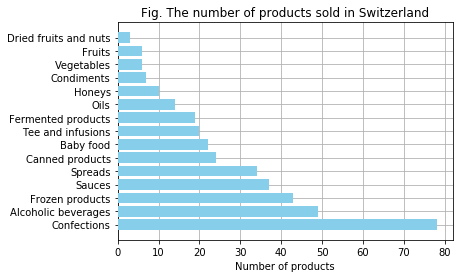

In [208]:
# Extract the 15 most frequent categories and number of occurances.
categories = cleaned_categories#target_categories.toPandas() 
categories = categories.head(15)

# Plot the most frequent categories
fig, ax = plt.subplots()
ax.grid(zorder=-1)
plt.barh(categories.category_main, categories.Count, zorder=3, color='skyblue')
plt.xlabel('Number of products')   
plt.title('Fig. The number of products sold in European Union')
ax.invert_yaxis() 
plt.show()

### Switzerland

## Manufacturing places of products

TODO: VERIFY what the cleaning process is doing...seems that something really weird is happening...according to this Switzerland is not importing from any other country...
Additionally, in "mapping countries" the assignation seems to have several pitfalls of assignation (does not seem to be insignificant).

### European Union

In [193]:
# Find dominant importers of ingredients
eu_sold_data.createOrReplaceTempView("eu_sold_data")
target_manufacture = spark.sql("SELECT manufacturing_places, COUNT(manufacturing_places) FROM eu_sold_data GROUP BY manufacturing_places ORDER BY COUNT(manufacturing_places) DESC")
target_manufacture = target_manufacture.withColumnRenamed('count(manufacturing_places)' , 'Count')
print("Number of Importers:\n" + str(target_manufacture.count()))
target_manufacture.show(5)

Number of Importers:
57
+--------------------+-----+
|manufacturing_places|Count|
+--------------------+-----+
|                  ct|48254|
|                  sp| 3246|
|                  gm| 2194|
|                  be|  970|
|                  up|  934|
+--------------------+-----+
only showing top 5 rows



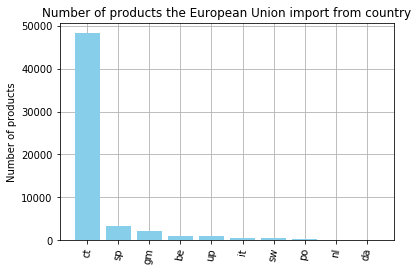

In [187]:
# Extract the 10 most important countries and number of occurances in ingredients.
manufacture_countries = target_manufacture.toPandas() 
manufacture_countries = manufacture_countries.head(10)

# Plot the number of products imported by 10 most important countries
fig, ax = plt.subplots()
ax.grid(zorder=-1)
plt.bar(manufacture_countries.manufacturing_places, manufacture_countries.Count, zorder=3, color='skyblue')
plt.ylabel('Number of products')   
plt.xticks(manufacture_countries.manufacturing_places, rotation='80')
plt.title('Number of products the European Union import from country')
plt.show()

### Switzerland

In [189]:
# Find dominant importers of ingredients
swiss_sold_data.createOrReplaceTempView("swiss_sold_data")
target_swiss_manufacture = spark.sql("SELECT manufacturing_places, COUNT(manufacturing_places) FROM swiss_sold_data GROUP BY manufacturing_places ORDER BY COUNT(manufacturing_places) DESC")
target_swiss_manufacture = target_swiss_manufacture.withColumnRenamed('count(manufacturing_places)' , 'Count')
print("Number of Importers:\n" + str(target_swiss_manufacture.count()))

Number of Importers:
1


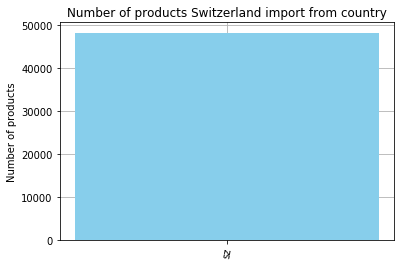

In [190]:
# Extract the 10 most important countries and number of occurances in ingredients.
manufacture_swiss_countries = target_swiss_manufacture.toPandas() 
manufacture_swiss_countries = manufacture_swiss_countries.head(10)

# Plot the number of products imported by 10 most important countries
fig, ax = plt.subplots()
ax.grid(zorder=-1)
plt.bar(manufacture_swiss_countries.manufacturing_places, manufacture_countries.Count, zorder=3, color='skyblue')
plt.ylabel('Number of products')   
plt.xticks(manufacture_swiss_countries.manufacturing_places, rotation='80')
plt.title('Number of products Switzerland import from country')
plt.show()

## Principal categories of imported products

### European Union

### Switzerland

## Evolution of local consumption in Switzerland

In [ ]:
# store products that are manufactured in Switzerland
swiss_manu_data = off_p_df.filter(off_p_df["manufacturing_places"].rlike(filter_ch))

swiss_manu_size = swiss_manu_data.count()
print("swiss_manufactored data Size:\n" + str(swiss_manu_size))

In [ ]:
# store products that are both manufactured and originate from Switzerland
swiss_origin_manu_data = off_p_df.filter(off_p_df["origins"].rlike(filter_ch) & off_p_df["manufacturing_places"].rlike(filter_ch))

swiss_origin_manu_size = swiss_origin_manu_data.count()
print("swiss_origin_manufactored data Size:\n" + str(swiss_origin_manu_size))

In [ ]:
#count products whose ingredients from switzerland but which were not manufactured in Switzerland
swiss_origin_tot = swiss_origin_data.filter(~ swiss_origin_data["manufacturing_places"].rlike(filter_ch)).count()

#Total of products sold in Switzerland
swiss_sold_tot = swiss_sold_data.count()

#count products that do not have swiss ingredients
swiss_manu_tot = swiss_manu_data.filter(~ swiss_manu_data["origins"].rlike(filter_ch)).count()

#products that are sold in Switzerland but that were not manufactured in CH and that do not have swiss ingredients
non_swiss_sold_tot = swiss_sold_data.filter(~ swiss_sold_data["manufacturing_places"].rlike(filter_ch) & ~swiss_sold_data["origins"].rlike(filter_ch)).count()

#total of products that are both manufactured and has ingredients from Switzerland
swiss_origin_manu_tot = swiss_origin_manu_data.count()

labels = 'Swiss ingredients (but not manufactured in Switzerland)', 'Manufactured in Switzerland (with no swiss ingredients)', 'Completely foreign products', 'Both swiss ingredients and manufactured in Switzerland'
sizes = [swiss_origin_tot, swiss_manu_tot, non_swiss_sold_tot, swiss_origin_manu_tot]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportions for a total of ' + str(swiss_sold_tot) + ' products sold in Switzerland')

plt.show()

According to above chart, we can see that Switzerland tend to use local ingredients to manufacture products. Since most of products manufactured in Switzerland are produced by mostly Swiss ingredients.

In [ ]:
#Store products that are not manufactured in Switzerland
non_swiss_sold = swiss_sold_data.filter(~swiss_sold_data["manufacturing_places"].rlike(filter_ch))

non_swiss_sold_size = non_swiss_sold.count()
print("Non swiss/Sold in Switzerland data Size:\n" + str(non_swiss_sold_size))

In [ ]:
#Store products that are manufactured in Switzerland
swiss_m_sold = swiss_sold_data.filter(swiss_sold_data["manufacturing_places"].rlike(filter_ch))

swiss_m_sold_size = swiss_m_sold.count()
print("Swiss/Sold in Switzerland data Size:\n" + str(swiss_m_sold_size))

In [ ]:
# Plot the number Swiss vs non-swiss products (Manufacturing)
fig, ax = plt.subplots()
titles = ['Manufactured in Switzerland', 'Not manufactured in Switzerland']
plt.bar(titles, [swiss_m_sold_size, non_swiss_sold_size])
plt.ylabel('Number of products sold in Switzerland')   
plt.xticks(titles)
plt.title('Fig. Manufacturing products in Switzerland')
plt.show()

Out of __762__ products sold in Switzerland, Just about __51%__ of them was manufactured in Switzerland.

The dataset is not concistent with the country or places name, therefore, we have to clean the data by trying to unify a maximum the places names. First the database http://download.geonames.org/export/dump/ was used in order to match all the different ways of naming a country to a single convention but since there are some rows which need human intelligence to process(for example some fields contain name of ingredient or details) in the end we prefered to clean data manually. 

In [ ]:
cleaned_countries = pd.read_csv("cleaning_data/origins_cleaning.csv")

# Flatten origins column
origins_p = non_swiss_sold.withColumn('origins', F.explode_outer(F.split('origins', ',')))

# Clean origins countries
for index, row in cleaned_countries.iterrows():
    if(str(row['replace_with']) != "nan"):
        origins_p = origins_p.withColumn('origins', F.regexp_replace('origins', "^" + row['origins'] + "$", row['replace_with']))
    else:
        origins_p = origins_p.withColumn('origins', F.regexp_replace('origins', row['origins'], "Not Specified"))

In [ ]:
# Find dominant importers of ingredients

origins_p.createOrReplaceTempView("origins_p")
target_origins = spark.sql("SELECT origins, COUNT(origins) FROM origins_p GROUP BY origins ORDER BY COUNT(origins) DESC")
target_origins = target_origins.withColumnRenamed('count(origins)' , 'Count')

print("Number of ingredient importers:\n" + str(target_origins.count()))

In [ ]:
target_origins.show(5)

In [ ]:
# Extract the 10 most important countries and number of occurances in ingredients.
origin_countries = target_origins.toPandas() 
origin_countries = origin_countries.head(10)

# Plot the number of products imported by 10 most important countries
fig, ax = plt.subplots()
ax.grid(zorder=-1)
plt.bar(origin_countries.origins, origin_countries.Count, zorder=3, color='skyblue')
plt.ylabel('Number of products')   
plt.xticks(origin_countries.origins, rotation='80')
plt.title('Fig. The number of products which ingredients are from the 10 most frequent countries')
plt.show()

In [ ]:
# Export origins to CSV 
target_origins.select("origins").toPandas().to_csv('output/origins.csv')

Now that we found the most important countries in case of producing ingredients for products which are imported to Switzerland, We should take the same approach to find the most important manufacturers of this products.

In [ ]:
# Flatten manufacturing_places column
manufacturers_p = non_swiss_sold.withColumn('manufacturing_places', F.explode_outer(F.split('manufacturing_places', ',')))

# Clean manufacturers countries
for index, row in cleaned_countries.iterrows():
    if(str(row['replace_with']) != "nan"):
        manufacturers_p = manufacturers_p.withColumn('manufacturing_places', F.regexp_replace('manufacturing_places', "^" + row['origins'] + "$", row['replace_with']))
    else:
        manufacturers_p = manufacturers_p.withColumn('manufacturing_places', F.regexp_replace('manufacturing_places', row['origins'], "Not Specified"))


In [ ]:
# Find dominant importers (manufacturers)

manufacturers_p.createOrReplaceTempView("manufacturers_p")
target_manufacturers = spark.sql("SELECT manufacturing_places, COUNT(manufacturing_places) FROM manufacturers_p GROUP BY manufacturing_places ORDER BY COUNT(manufacturing_places) DESC")
target_manufacturers = target_manufacturers.withColumnRenamed('count(manufacturing_places)' , 'Count')
# target_manufacturers.show()

print("Number of Manufacturers:\n" + str(target_manufacturers.count()))

In [ ]:
# Extract the 10 most important manufacturers countries and number of occurances.
manufacturer_countries = target_manufacturers.toPandas() 
manufacturer_countries = manufacturer_countries.head(10)

# Plot the number of products manufactured by 10 most important countries
fig, ax = plt.subplots()
ax.grid(zorder=-1)
plt.bar(manufacturer_countries.manufacturing_places, manufacturer_countries.Count, zorder=3, color='skyblue')
plt.ylabel('Number of products')   
plt.xticks(manufacturer_countries.manufacturing_places, rotation='80')
plt.title('Fig. The number of products manufactured by 10 most important countries')
plt.show()

In [ ]:
# Export manufacturing_places to CSV 
target_manufacturers.select("manufacturing_places").toPandas().to_csv('output/manufacturing_places.csv')

### Working with products' categories

We would like to find which countries import what products. In order to answer to this question, first we extract categories corresponding to the products sold in Switzerland but not manufactured in this country. Then we will combine the information provided for manufacturing places of these products with corresponding category. 

In the end we will extract the 5 most important importers of each category.

In [ ]:
extra_info_df = ' categories '
categories_df = spark.sql("SELECT" + p_id_col + extra_info_df + " FROM data_main")
categories_df.show(10)

In [ ]:
categories_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in traces_df.columns]).show()

In [ ]:
# Join table of categories with table of target products (Sold in Switzerland but not manufactured in it)
non_swiss_sold.createOrReplaceTempView("target_products_df")
categories_df.createOrReplaceTempView("categories_df")
joined_df = spark.sql("SELECT p.code, c.categories, p.origins, p.manufacturing_places, p.countries  FROM target_products_df p INNER JOIN categories_df c ON p.code = c.code")

In [ ]:
joined_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in joined_df.columns]).show()

According to above table, just 15 products do not have category. 

In [ ]:
joined_df.createOrReplaceTempView("target_products_cats")
sql_filter = "SELECT * FROM target_products_cats WHERE categories is not NULL"
target_products_categories_p = spark.sql(sql_filter)

print("Number of Products sold in Switzerland with categories:\n" + str(target_products_categories_p.count()))

In [ ]:
target_products_categories_p.show(5)

In [ ]:
# Flatten categories column
target_products_categories_p = target_products_categories_p.withColumn('categories', F.explode_outer(F.split('categories', ',')))

# Remove occurances of en: in name of categories
target_products_categories_p = target_products_categories_p.withColumn('categories', F.regexp_replace('categories', 'en:', ''))

target_products_categories_p.show(5)

In [ ]:
# Find dominant categories
target_products_categories_p.createOrReplaceTempView("target_products_categories_p")
target_categories = spark.sql("SELECT categories, COUNT(categories) FROM target_products_categories_p GROUP BY categories ORDER BY COUNT(categories) DESC")
target_categories = target_categories.withColumnRenamed('count(categories)' , 'Count')
target_categories.show()

print("Number of Categories:\n" + str(target_categories.count()))

According to above table not all categories are independant and they may contain similar products. We did not change categories for this milestone but we would like to merge some categories in future to have better distinction between countries which import these products. 

In [ ]:
# Export Categories to CSV 
target_categories.toPandas().to_csv('output/categories.csv')

In [ ]:
# Extract the 15 most frequent categories and number of occurances.
categories = target_categories.toPandas() 
categories = categories.head(15)

# Plot the most frequent categories
fig, ax = plt.subplots()
ax.grid(zorder=-1)
plt.barh(categories.categories, categories.Count, zorder=3, color='skyblue')
plt.xlabel('Number of products')   
plt.title('Fig. The number of products sold in Switzerland')
ax.invert_yaxis() 
plt.show()

In [ ]:
cleaned_countries = pd.read_csv("cleaning_data/origins_cleaning.csv")

In [ ]:
# Extract the most important manufacturer countries for 15 most frequent categories

categories_countires_p = target_products_categories_p.withColumn('manufacturing_places', F.explode_outer(F.split('manufacturing_places', ',')))

# Clean manufacturers countries
for index, row in cleaned_countries.iterrows():
    if(str(row['replace_with']) != "nan"):
        categories_countires_p = categories_countires_p.withColumn('manufacturing_places', F.regexp_replace('manufacturing_places', "^" + row['origins'] + "$", row['replace_with']))
    else:
        categories_countires_p = categories_countires_p.withColumn('manufacturing_places', F.regexp_replace('manufacturing_places', row['origins'], "Not Specified"))

categories_countires_p = categories_countires_p.withColumn('categories', F.explode_outer(F.split('categories', ',')))
products_cats_df = categories_countires_p.toPandas()

countries_cats = []
cat = "Snacks sucrés"
for index, row in categories.iterrows():
    temp_df = products_cats_df[(products_cats_df.categories == row.categories)].groupby('manufacturing_places').count().sort_values(by=['code'], ascending=False).head(5)
    countries_cats.append(temp_df)

# Each element of countries_cats is a dataframe containing the most important manufacturers
# of the corresponding category

i = 0
print("category: " + str(categories.iloc[i].categories))
print("The most important manufacturers:")
print(countries_cats[0].head(3).index.values)

We will use extracted information about the most important manufacturer countries for 15 most frequent categories for our visualization.

## Descriptive Analysis

In [ ]:
openfood = pd.read_csv(DATA_FOLDER + openfood_file, sep = '\t')

In [ ]:
foodSwitzerland = openfood[openfood['countries_tags']=="en:switzerland"]

In [ ]:
nbProdSwit = len(foodSwitzerland)
print("Number of products: ", nbProdSwit)

# first perspective: Compare old vs new products inside the dataset

A product in the dataset is considered "old" if its description was uploaded to the dataset before February 2017. By the contrary, it is considered as "new" if its description was uploaded after that date.

_As that definition is a little rigid, in order to get closer to the real situation, the following assumption is made: From the total products uploaded to the dataset after February 2017, 20% are old products._  

A first perspective to tackle the research question, is to compare how in this more than 6 years of existance of the dataset, the characteristics of the products have changed. Specifically, we would like to know if there have been some changes in the origin of the primary resources, or in the origin of the manufacture or in the labels of the products.

The study of the evolution in time of each one of those features, will include an __exploratory data analysis__.
Finally, a study including the three features will be done, aiming to find an aggregated differentiated behavior in time, reflected in different clusters of periods of time. For that the __K-modes algorithm__ will be used.

In [ ]:
print("Date of first upload: ", min(foodSwitzerland['created_datetime']))
print("Date of last upload retrieved: ", max(foodSwitzerland['created_datetime']))

In [ ]:
foodSwitzerland['created_datetime'] = pd.to_datetime(foodSwitzerland['created_datetime'])
foodSwitzerland = foodSwitzerland.sort_values(by='created_datetime')

The uploads of products sold in Switzerland, behaves differently in time. Taking into account the histogram presented below, two periods of time are defined:
- Period 1: Created for studying the behaviour from "old" products. Products uploaded before Feb 2017.
- Period 2: Created for studying the behaviour from "new" products. Products uploaded after Feb 2017.

In [ ]:
rateOldInNew = 0.2
old_products = len(foodSwitzerland[foodSwitzerland['created_datetime']<"2017-03-01 00:00:00"])
print("Old products: ", old_products + (len(foodSwitzerland)-old_products)*(rateOldInNew))
print("New products: ", (len(foodSwitzerland)-old_products)*(1-rateOldInNew))
foodSwitzerland['created_datetime'].hist()

Before making subdivision of data:

In [ ]:
filter_ch = '[Ss]witzerland|[Ss]uisse|[Ss]chweiz|[Ss]vizerra'
filter_local = '[Ss]witzerland|[Ss]uisse|[Ss]chweiz|[Ss]vizerra|[Ll]ocal'

place = pd.Series(['Other country','Switzerland', 'No information'], index=[0,1,2])
refLabel = pd.Series(['Other Label','Related with Switzerland', 'No information'], index=[0,1,2]) 

foodSwitzerland["originsCat"] = foodSwitzerland["origins"].str.contains(filter_ch,regex=True).map(place,na_action='ignore')
foodSwitzerland["manuCat"] = foodSwitzerland["manufacturing_places"].str.contains(filter_ch,regex=True).map(place,na_action='ignore')
foodSwitzerland["labCat"] = foodSwitzerland["labels_tags"].str.contains(filter_local,regex=True).map(refLabel,na_action='ignore')

Now, let's do the subdivision in the two periods, taking care of our assumption of 20%:

In [ ]:
foodSwitzerlandBef = foodSwitzerland[foodSwitzerland['created_datetime']<"2017-03-01 00:00:00"]
foodSwitzerlandAft = foodSwitzerland[foodSwitzerland['created_datetime']>="2017-03-01 00:00:00"]

befInAft = foodSwitzerlandAft.sample(n=int(rateOldInNew*len(foodSwitzerlandAft)), replace=False)
foodSwitzerlandBef = pd.concat([foodSwitzerlandBef,befInAft],axis=0)

for i in range (0,len(befInAft)):
    foodSwitzerlandAft = foodSwitzerlandAft[foodSwitzerlandAft['code']!=befInAft['code'].iloc[i]]
print("Number of Old products: ", np.shape(foodSwitzerlandBef))
print("Number of New products: ", np.shape(foodSwitzerlandAft))

### 2.1 Study of the evolution in time of each one of the interest features

### 2.1.1 With respect to: Origin of the primary resources

First, bootstrapping for include confidence intervals to results

In [ ]:
#before
propSB_100ite = np.zeros (100)
propOCB_100ite = np.zeros (100)
#after
propSA_100ite = np.zeros (100)
propOCA_100ite = np.zeros (100)

for iteration in range(0,100):
    #before
    temp_bef = foodSwitzerlandBef["originsCat"].sample(n=len(foodSwitzerlandBef), replace=True)
    propSB_100ite[iteration] = (sum(temp_bef=="Switzerland")/len(foodSwitzerlandBef))
    propOCB_100ite[iteration] = sum(temp_bef=="Other country")/len(foodSwitzerlandBef)
    #after
    temp_aft = foodSwitzerlandAft["originsCat"].sample(n=len(foodSwitzerlandAft), replace=True)
    propSA_100ite[iteration] = sum(temp_aft=="Switzerland")/len(foodSwitzerlandAft)
    propOCA_100ite[iteration] = sum(temp_aft=="Other country")/len(foodSwitzerlandAft)
    
    #Relation of time evolution and difference of products in each categories
    difpropB = propSB_100ite[iteration]-propOCB_100ite[iteration]
    difpropA = propSB_100ite[iteration]-propOCA_100ite[iteration]

#Calculating standard deviation of count of each category
SBstd = np.std(propSB_100ite)
OCBstd = np.std(propOCB_100ite)
#Calculating standard deviation of count of each category
SAstd = propSA_100ite.std()
OCAstd = propOCA_100ite.std()

Then, plotting of behavior 

In [ ]:
#Report information of NAN cases
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
print("There was not information for ",len(foodSwitzerlandBef["originsCat"])-sum(foodSwitzerlandBef["originsCat"]=="Switzerland")-sum(foodSwitzerlandBef["originsCat"]=="Other country")," products in the period 1.")
print("There was not information for ",len(foodSwitzerlandAft["originsCat"])-sum(foodSwitzerlandAft["originsCat"]=="Switzerland")-sum(foodSwitzerlandAft["originsCat"]=="Other country")," products in the period 2.")

#Plot origin of primary resources by periods
plt.subplot(1,2,1)
(foodSwitzerlandBef["originsCat"].value_counts()/len(foodSwitzerlandBef["originsCat"])).plot(kind='bar', yerr = [SBstd,OCBstd],title='Period 1')
plt.subplot(1,2,2)
(foodSwitzerlandAft["originsCat"].value_counts()/len(foodSwitzerlandAft["originsCat"])).plot(kind='bar', yerr = [SAstd,OCAstd],title='Period 2')

plt.show()

Most of old products have as origin of primary resources Switzerland. However, in new products, the origin of primary resources is for Switzerland and Other countries statistically the same.

### 2.1.2 With respect to: Manufacture

First, bootstrapping for include confidence intervals to results

In [ ]:
#before
propSB_100ite = np.zeros (100)
propOCB_100ite = np.zeros (100)

#after
propSA_100ite = np.zeros (100)
propOCA_100ite = np.zeros (100)

for iteration in range(0,100):
    #before
    temp_bef = foodSwitzerlandBef["manuCat"].sample(n=len(foodSwitzerlandBef), replace=True)
    propSB_100ite[iteration] = sum(temp_bef=="Switzerland")/len(foodSwitzerlandBef)
    propOCB_100ite[iteration] = sum(temp_bef=="Other country")/len(foodSwitzerlandBef)
    #after
    temp_aft = foodSwitzerlandAft["manuCat"].sample(n=len(foodSwitzerlandAft), replace=True)
    propSA_100ite[iteration] = sum(temp_aft=="Switzerland")/len(foodSwitzerlandAft)
    propOCA_100ite[iteration] = sum(temp_aft=="Other country")/len(foodSwitzerlandAft)
    

#Calculating standard deviation of count of each category
SBstd = propSB_100ite.std()
OCBstd = propOCB_100ite.std()
#Calculating standard deviation of count of each category
SAstd = propSA_100ite.std()
OCAstd = propOCA_100ite.std()

In [ ]:
#Report information of NAN cases
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
print("There was not information for ",len(foodSwitzerlandBef["manuCat"])-sum(foodSwitzerlandBef["manuCat"]=="Switzerland")-sum(foodSwitzerlandBef["manuCat"]=="Other country")," products in the period 1.")
print("There was not information for ",len(foodSwitzerlandAft["manuCat"])-sum(foodSwitzerlandAft["manuCat"]=="Switzerland")-sum(foodSwitzerlandAft["manuCat"]=="Other country")," products in the period 2.")

#Plot origin of primary resources by periods
plt.subplot(1,2,1)
(foodSwitzerlandBef["manuCat"].value_counts()/len(foodSwitzerlandBef["manuCat"])).plot(kind='bar', yerr = [SBstd,OCBstd],title='Period 1')
plt.subplot(1,2,2)
(foodSwitzerlandAft["manuCat"].value_counts()/len(foodSwitzerlandBef["manuCat"])).plot(kind='bar', yerr = [SAstd,OCAstd],title='Period 2')

plt.show()

Most of old products were manufactured in Switzerland. However, in new products, the manufacture is for Switzerland and Other countries statistically the same.

### 2.1.3 With respect to: Labels

In [ ]:
#before
propSB_100ite = np.zeros (100)
propOCB_100ite = np.zeros (100)
#after
propSA_100ite = np.zeros (100)
propOCA_100ite = np.zeros (100)

for iteration in range(0,100):
    #before
    temp_bef = foodSwitzerlandBef["labCat"].sample(n=len(foodSwitzerlandBef), replace=True)
    propSB_100ite[iteration] = sum(temp_bef=="Related with Switzerland")/len(foodSwitzerlandBef)
    propOCB_100ite[iteration] = sum(temp_bef=="Other Label")/len(foodSwitzerlandBef)
    #after
    temp_aft = foodSwitzerlandAft["labCat"].sample(n=len(foodSwitzerlandAft), replace=True)
    propSA_100ite[iteration] = sum(temp_aft=="Related with Switzerland")/len(foodSwitzerlandAft)
    propOCA_100ite[iteration] = sum(temp_aft=="Other Label")/len(foodSwitzerlandAft)
    
    #Relation of time evolution and difference of products in each categories
    difpropB = propSB_100ite[iteration]-propOCB_100ite[iteration]
    difpropA = propSB_100ite[iteration]-propOCA_100ite[iteration]

#Calculating standard deviation of count of each category
SBstd = propSB_100ite.std()
OCBstd = propOCB_100ite.std()
#Calculating standard deviation of count of each category
SAstd = propSA_100ite.std()
OCAstd = propOCA_100ite.std()

In [ ]:
#Report information of NAN cases
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
print("There was not information for ",len(foodSwitzerlandBef["labCat"])-sum(foodSwitzerlandBef["labCat"]=="Switzerland")-sum(foodSwitzerlandBef["labCat"]=="Other country")," products in the period 1.")
print("There was not information for ",len(foodSwitzerlandAft["labCat"])-sum(foodSwitzerlandAft["labCat"]=="Switzerland")-sum(foodSwitzerlandAft["labCat"]=="Other country")," products in the period 2.")

#Plot origin of primary resources by periods
plt.subplot(1,2,1)
(foodSwitzerlandBef["labCat"].value_counts()/len(foodSwitzerlandBef["labCat"])).plot(kind='bar', yerr = [SBstd,OCBstd],title='Period 1')
plt.subplot(1,2,2)
(foodSwitzerlandAft["labCat"].value_counts()/len(foodSwitzerlandBef["labCat"])).plot(kind='bar', yerr = [SAstd,OCAstd],title='Period 2')

plt.show()

For the two periods studied, other labels are more frequent than the related with Switzerland

## Future plan

### Improving data cleaning for countries 

Although we cleaned the data of name of countries but about 200 are still remained.

### Extend research questions to Europe

After talking with TA, we decided to extend our research questions to Europe in order to have more data. The similar approach will be taken for answering our main questions about Europe.

### Evaluate and complement our results

We would like to complement our results using following databases:
- Additional datasets “Evolution de la consommation de denrées alimentaires en Suisse” (https://opendata.swiss/fr/dataset/entwicklung-des-nahrungsmittelverbrauches-in-der-schweiz-je-kopf-und-jahr1) and “Dépenses fédérales pour l’agriculture et l’alimentation” (https://opendata.swiss/fr/dataset/bundesausgaben-fur-die-landwirtschaft-und-die-ernahrung1) from https://opendata.swiss/fr/group/agriculture

- A last additional dataset for the second question of the project https://www.gate.ezv.admin.ch/swissimpex/public/bereiche/waren/result.xhtml Total of imports of agriculture, forestry and fishing goods

### Find the most important characteristic of Swiss-made products

After answering our main research questions we would like to find which products are likely to import to Switzerland. To answer this question we would like to train a classifier in order to see which features are the most important features to decide if a product is Swiss made or not.

### Improve our assumption about date of entering products to the Swiss market

Study of the evolution in time of the interest features combined
- The k-modes and other machine learning algorithms are expected to be done for the milestone 3.